In [1]:
# Image Super Resolution using Autoencoders
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from skimage.util import random_noise
import glob

In [2]:
# loading images 
images = glob.glob('../../GPU testings/data/lfw/**/*.jpg')

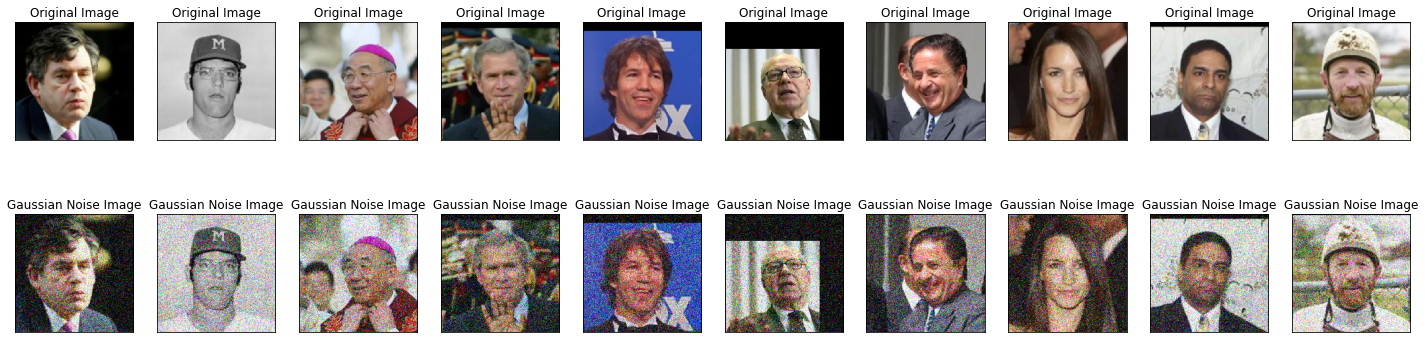

In [3]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  index = np.random.randint(0, len(images))
  img = image.load_img(str(images[index]), target_size=(192,192,3))
  img = image.img_to_array(img)/255.
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
  ax = plt.subplot(3, n, i+1+n)
  noisy_image = random_noise(img, 'gaussian', var=0.05)
  plt.imshow(noisy_image)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Gaussian Noise Image')
plt.show()

In [4]:
# Building a Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

# Building the Encoder
input_img = Input(shape=(192, 192, 3))
l1 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.2)(l3)
l4 = Conv2D(64, (3, 3),  padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l6 = Dropout(0.2)(l6)
l7 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)

l8 = MaxPooling2D(padding='same')(l7)
l8 = Dropout(0.2)(l8)
l9 = Conv2D(256, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)

In [5]:
# Building the Decoder
l10 = UpSampling2D()(l9)
l10 = Dropout(0.2)(l10)
l11 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l10)

l12 = add([l7, l11])
l13 = UpSampling2D()(l12)
l13 = Dropout(0.2)(l13)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l13)
l15 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l14)

l16 = add([l5, l14])
l17 = UpSampling2D()(l16)
l17 = Dropout(0.2)(l17)
l18 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l17)
l19 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l18)

l20 = add([l18, l2])

In [6]:
# chan = 3, for RGB
decoded = Conv2D(3, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l20)

# Create our network
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 96, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

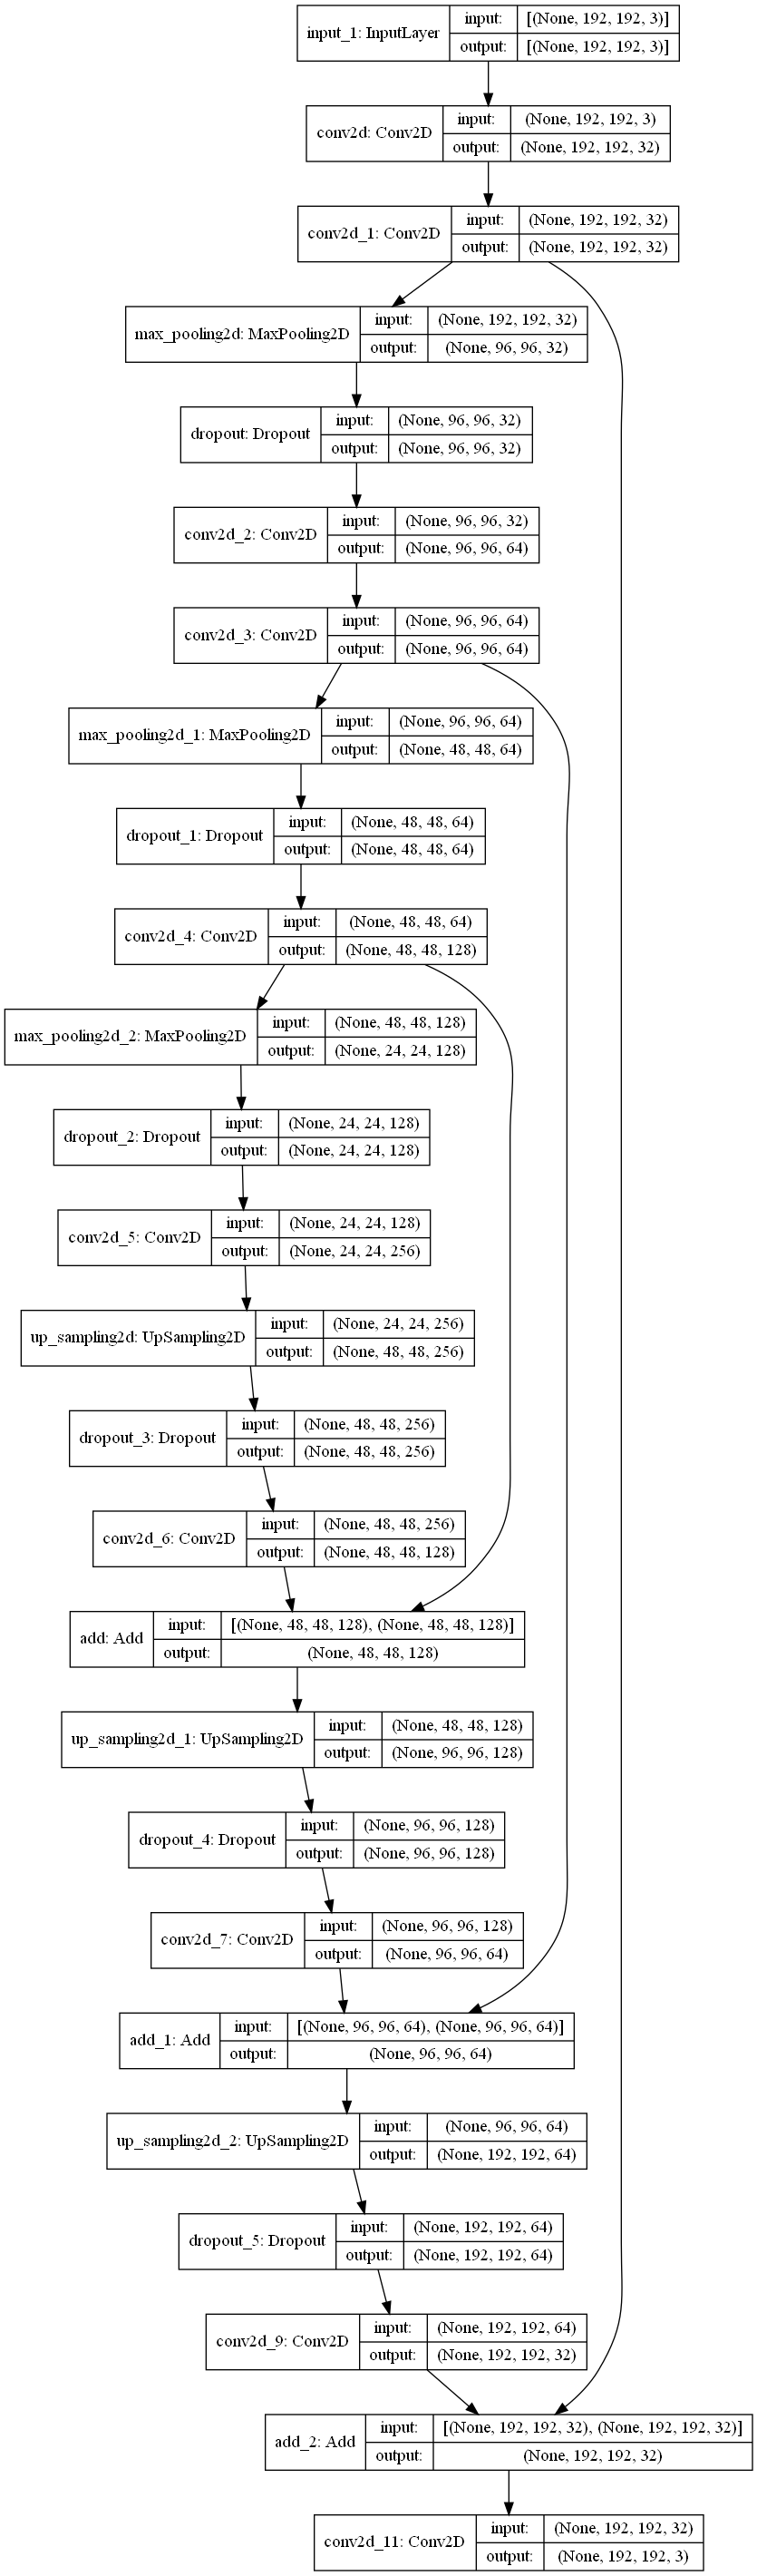

In [7]:
tf.keras.utils.plot_model(
    autoencoder,
    # to_file="AE_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

In [8]:
# Training the Model
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5,
                             min_lr=0.00001, mode='auto', cooldown=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint =  ModelCheckpoint('GN_Denoising_AE.h5', save_best_only = True, monitor="val_accuracy")
callbacks = [reduce_lr, early_stop, model_checkpoint]

In [9]:
# Training the model
x_train_n = []
x_train_noisy = []
print('Loading Train Data.....')
progress = tqdm(total = 10000, position = 0)
for x in range(10000):
  try:
      index = np.random.randint(0, len(images))
      img = image.load_img(str(images[index]), target_size=(192,192,3))
      img = image.img_to_array(img)/255.
      x_train_n.append(img)
      x_train_noisy.append(random_noise(img, 'gaussian', var=0.05))

      del images[index]
      progress.update(1)
  except:
      progress.update(1)
      print("Error loading image")

Loading Train Data.....


100%|█████████▉| 9998/10000 [01:29<00:00, 68.10it/s] 

In [10]:
print("Length: ", len(x_train_n))
print('Training the model....')
history_ae = autoencoder.fit(np.array(x_train_noisy), np.array(x_train_n),
              epochs=100,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

Length:  10000
Training the model....
Epoch 1/100


100%|██████████| 10000/10000 [01:40<00:00, 68.10it/s]

266/266 [==============================] - 85s 285ms/step - loss: 0.0223 - accuracy: 0.6291 - val_loss: 0.0043 - val_accuracy: 0.7214
Epoch 2/100


d:\Users\KalburgS\Anaconda3\envs\pygames\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


266/266 [==============================] - 72s 269ms/step - loss: 0.0034 - accuracy: 0.7565 - val_loss: 0.0031 - val_accuracy: 0.7564
Epoch 3/100
266/266 [==============================] - 72s 272ms/step - loss: 0.0029 - accuracy: 0.7800 - val_loss: 0.0028 - val_accuracy: 0.7772
Epoch 4/100
266/266 [==============================] - 72s 272ms/step - loss: 0.0026 - accuracy: 0.7975 - val_loss: 0.0026 - val_accuracy: 0.7842
Epoch 5/100
266/266 [==============================] - 72s 272ms/step - loss: 0.0024 - accuracy: 0.8036 - val_loss: 0.0025 - val_accuracy: 0.7901
Epoch 6/100
266/266 [==============================] - 72s 272ms/step - loss: 0.0023 - accuracy: 0.8091 - val_loss: 0.0023 - val_accuracy: 0.7939
Epoch 7/100
266/266 [==============================] - 73s 273ms/step - loss: 0.0022 - accuracy: 0.8135 - val_loss: 0.0022 - val_accuracy: 0.7861
Epoch 8/100
266/266 [==============================] - 73s 274ms/step - loss: 0.0021 - accuracy: 0.8173 - val_loss: 0.0022 - val_accurac

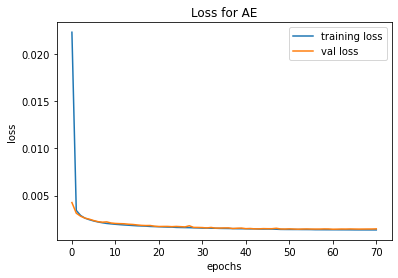

In [11]:
# Plotting graphs for loss
plt.plot(history_ae.history['loss'], label='training loss')
plt.plot(history_ae.history['val_loss'], label='val loss')
plt.title('Loss for AE')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

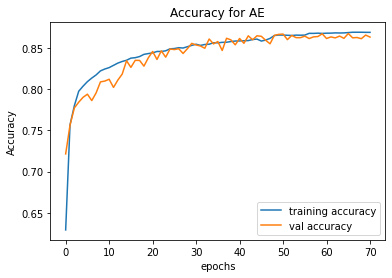

In [12]:
# Plotting graphs for accuracy
plt.plot(history_ae.history['accuracy'], label='training accuracy')
plt.plot(history_ae.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for AE')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

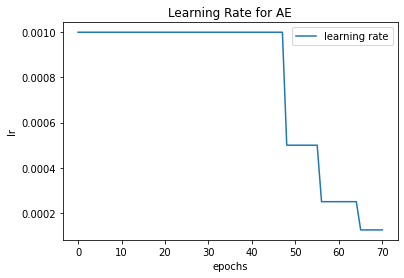

In [13]:
# Plotting graphs for lr
plt.plot(history_ae.history['lr'], label='learning rate')
plt.title('Learning Rate for AE')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

In [14]:
x_test_n = []
x_test_noisy = []
progress = tqdm(total= len(images), position=0)
for img in images:
  img = image.load_img(img, target_size=(192,192,3))
  img = image.img_to_array(img)/255.
  x_test_n.append(img)
  x_test_noisy.append(random_noise(img, 'gaussian', var=0.05))
  progress.update(1)

100%|█████████▉| 707/709 [00:08<00:00, 86.21it/s]

In [15]:
#Evalutaing the model on test_data set
print('AE Loss and Accuracy on Test dataset....')
results_AE = autoencoder.evaluate(np.array(x_test_noisy), np.array(x_test_n))
predictions_AE = autoencoder.predict(np.array(x_test_noisy))

# Represeting Model as JSON String
autoencoder_json = autoencoder.to_json()
with open('GN_Denoising_AE_model.json', 'w') as json_file:
  json_file.write(autoencoder_json)

AE Loss and Accuracy on Test dataset....
23/23 [==============================] - 2s 76ms/step - loss: 0.0015 - accuracy: 0.8672 0s - los


In [16]:
# Building a CNN Model
input_img = Input(shape=(192, 192, 3))
l1 = Conv2D(16, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(16, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = Dropout(0.2)(l2)

l4 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = Dropout(0.2)(l5)

l7 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)
l8 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l7)
l9 = Dropout(0.2)(l8)

l10 = Conv2D(3, (3, 3), padding='same', activation=None,
                 activity_regularizer=regularizers.l1(10e-10))(l9)

# Create our network
cnn = Model(input_img, l10)

cnn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 192, 192, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 192, 192, 16)      2320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 192, 192, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 192, 192, 32)      4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 192, 192, 32)      9248      
_________________________________________________________________
dropout_7 (Dropout)          (None, 192, 192, 32)      0   

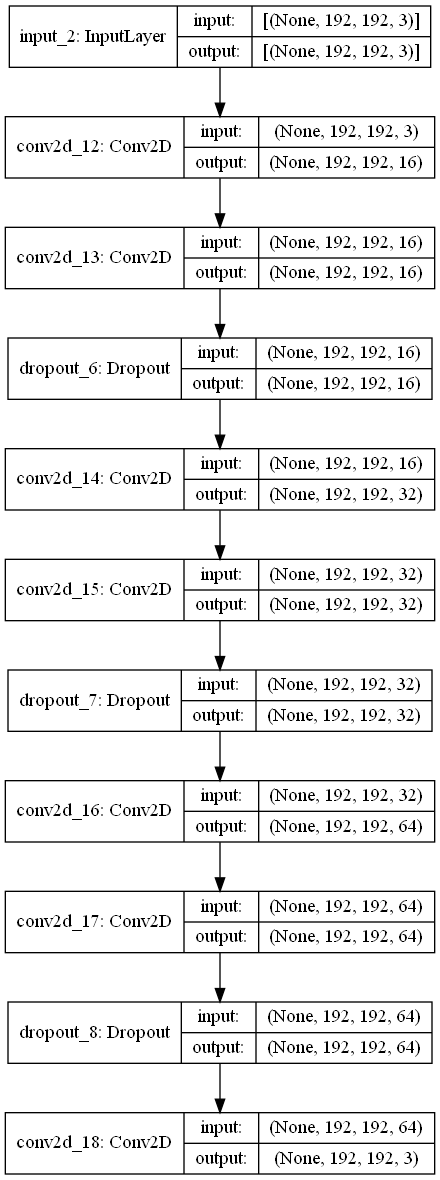

In [17]:
tf.keras.utils.plot_model(
    cnn,
    # to_file="CNN_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

In [19]:
# Training the cnn model
model_checkpoint =  ModelCheckpoint('GN_Denoising_CNN.h5', save_best_only = True, monitor="val_accuracy")
callbacks = [reduce_lr, early_stop, model_checkpoint]

print("Length: ", len(x_train_n))
print('Training the model....')
history_cnn = cnn.fit(np.array(x_train_noisy), np.array(x_train_n),
              epochs=100,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

Length:  10000
Training the model....
Epoch 1/100
266/266 [==============================] - 81s 279ms/step - loss: 0.0135 - accuracy: 0.6560 - val_loss: 0.0110 - val_accuracy: 0.7720
Epoch 2/100
266/266 [==============================] - 70s 264ms/step - loss: 0.0041 - accuracy: 0.7401 - val_loss: 0.0116 - val_accuracy: 0.7610
Epoch 3/100
266/266 [==============================] - 71s 265ms/step - loss: 0.0033 - accuracy: 0.7634 - val_loss: 0.0114 - val_accuracy: 0.7938
Epoch 4/100
266/266 [==============================] - 71s 267ms/step - loss: 0.0030 - accuracy: 0.7721 - val_loss: 0.0098 - val_accuracy: 0.7951
Epoch 5/100
266/266 [==============================] - 71s 267ms/step - loss: 0.0028 - accuracy: 0.7757 - val_loss: 0.0075 - val_accuracy: 0.7992
Epoch 6/100
266/266 [==============================] - 71s 268ms/step - loss: 0.0027 - accuracy: 0.7796 - val_loss: 0.0069 - val_accuracy: 0.8056
Epoch 7/100
266/266 [==============================] - 71s 268ms/step - loss: 0.0026 -

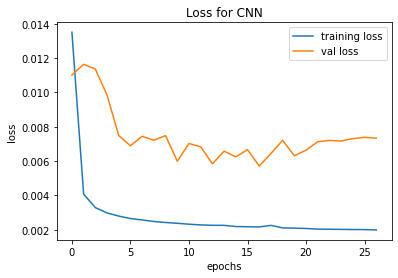

In [20]:
# Plotting graphs for loss
plt.plot(history_cnn.history['loss'], label='training loss')
plt.plot(history_cnn.history['val_loss'], label='val loss')
plt.title('Loss for CNN')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

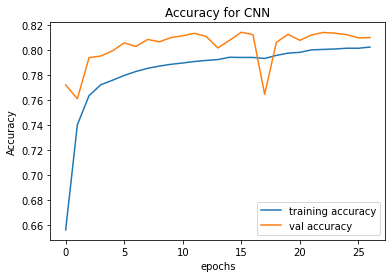

In [21]:
# Plotting graphs for accuracy
plt.plot(history_cnn.history['accuracy'], label='training accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for CNN')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

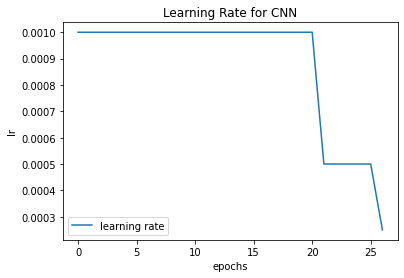

In [22]:
# Plotting graphs for lr
plt.plot(history_cnn.history['lr'], label='learning rate')
plt.title('Learning Rate for CNN')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

In [23]:
#Evalutaing the model on test_data set
print('CNN Loss and Accuracy on Test dataset...')
results_CNN = cnn.evaluate(np.array(x_test_noisy), np.array(x_test_n))
predictions_CNN = cnn.predict(np.array(x_test_noisy))

# Represeting Model as JSON String
cnn_json = cnn.to_json()
with open('GN_Denoising_CNN_model.json', 'w') as json_file:
  json_file.write(cnn_json)

CNN Loss and Accuracy on Test dataset...
23/23 [==============================] - 2s 75ms/step - loss: 0.0073 - accuracy: 0.8131


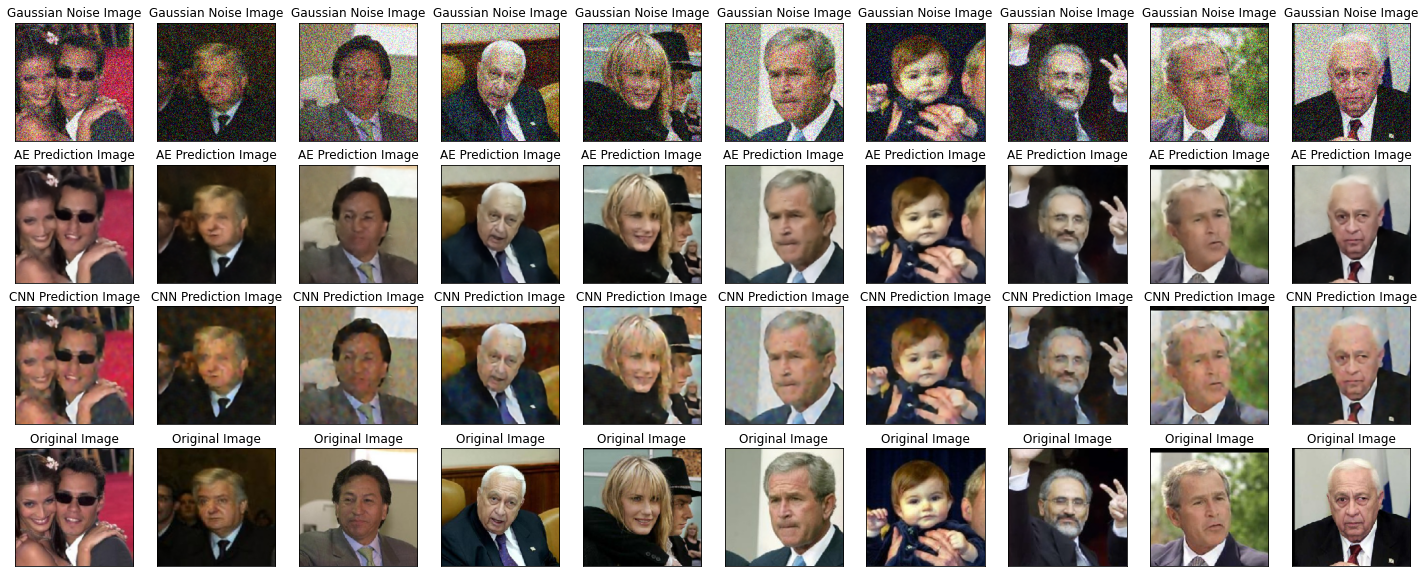

In [24]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(4, n, i+1)
  index = np.random.randint(0, len(x_test_n))
  act_img = image.array_to_img(x_test_noisy[index])
  plt.imshow(act_img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Gaussian Noise Image')
  ax = plt.subplot(4, n, i+1+n)
  pred_ae = image.array_to_img(predictions_AE[index])
  plt.imshow(pred_ae, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('AE Prediction Image')
  ax = plt.subplot(4, n, i+11+n)
  pred_cnn = image.array_to_img(predictions_CNN[index])
  plt.imshow(pred_cnn, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('CNN Prediction Image')
  ax = plt.subplot(4, n, i+21+n)
  plt.imshow(x_test_n[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
plt.show()